### Creating a test file from the inference test:

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path
from tqdm import tqdm

import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

from SEIR import NPI, setup, file_paths
from SEIR.utils import config
import pathlib
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [2]:
all_runs = {'Scenario Projections - Optimistic - 300x300':{
                'path':'s3pull/shauntrue/shaun/snpi/',
                'config':'s3pull/shauntrue/shaun/USA-20210117T182809/config_inference_med_statelevel_scnproj_optimistic.yml',
                'geodata': 's3pull/shauntrue/shaun/USA-20210117T182809/'},
            'State level - perturbation sd=0.01 - Seas Loc NPIs - 300x1000':{
                'path':'s3pull/shauntrue/shaun221/snpi/',
                'config':'s3pull/shauntrue/shaun221/USA-20210115T060221/config_inference_med_statelevel_SeasLocNPI.yml',
                'geodata':'s3pull/shauntrue/shaun221/USA-20210115T060221/'}
}

In [11]:
all_runs = {'Scenario hub - Fatigue - No Variant':{
                'path':'model_output/scenariomodhub/fatigue-novar/snpi/',
                'config':'../COVID19_USA/config_inference_scenarioproj_fatigue_29jan.yml',
                'geodata': '../COVID19_USA/'},
            'Scenario hub - Fatigue - Variant':{
                'path':'model_output/scenariomodhub/fatigue-var/snpi/',
                'config':'../COVID19_USA/config_inference_scenarioproj_fatigue_variant_29jan.yml',
                'geodata': '../COVID19_USA/'},
            'Scenario hub - Optimistic - Variant':{
                'path':'model_output/scenariomodhub/optimist-var/snpi/',
                'config':'../COVID19_USA/config_inference_scenarioproj_optimistic_variant_29jan.yml',
                'geodata': '../COVID19_USA/'},
            'Scenario hub - Optimistic - No Variant':{
                'path':'model_output/scenariomodhub/optimist-novar/snpi/',
                'config':'../COVID19_USA/config_inference_scenarioproj_optimistic_29jan.yml',
                'geodata': '../COVID19_USA/'},
}

In [25]:
betas = {}
for name, dc in all_runs.items():

    config.clear()
    config.read(user=False)
    config.set_file(dc['config'])
    scenario = 'inference'
    deathrate = 'med'
    spatial_config = config["spatial_setup"]
    stoch_traj_flag = True
    index = 0
    run_id = 0
    prefix = 0
    spatial_base_path = pathlib.Path(dc['geodata'] + spatial_config["base_path"].get())
    scenario = scenario
    deathrate = deathrate
    stoch_traj_flag= stoch_traj_flag # Truthy: stochastic simulation, Falsy: determnistic mean of the binomial draws
    nsim = 10
    interactive = False
    write_csv = False
    write_parquet = True
    npi_df = []

    s = setup.Setup(
        setup_name=config["name"].get() + "_" + str(scenario),
        spatial_setup=setup.SpatialSetup(
            setup_name=spatial_config["setup_name"].get(),
            geodata_file=spatial_base_path / spatial_config["geodata"].get(),
            mobility_file=spatial_base_path / spatial_config["mobility"].get(),
            popnodes_key=spatial_config["popnodes"].get(),
            nodenames_key=spatial_config["nodenames"].get()
        ),
        nsim=nsim,
        npi_scenario=scenario,
        npi_config=config["interventions"]["settings"][scenario],
        seeding_config=config["seeding"],
        ti=config["start_date"].as_date(),
        tf=config["end_date"].as_date(),
        interactive=interactive,
        write_csv=write_csv,
        write_parquet=write_parquet,
        dt=config["dt"].as_number(),
        first_sim_index = index,
        in_run_id = run_id,
        in_prefix = prefix,
        out_run_id = run_id,
        out_prefix = prefix
    )

    folder = [x for x in Path(dc['path']).glob('**') if not x.is_file()]

    folder.reverse()
    
    betas[name] = []
    
    maxfiles = 10

    for fold in [folder[0]]:
        print(fold)
        print(f'Exploring {str(fold)[:]} ... ', end = '')
        files_loaded = 0
        for hpar_fn in Path(str(fold)).rglob('*.parquet'):
            hpar_fn = str(hpar_fn)
            if ('chimeric' not in hpar_fn and files_loaded < maxfiles):
                #hpar =  pq.read_table(hpar_fn).to_pandas()
                #delay = int(list(hpar[(hpar['outcome']=='incidC') & (hpar['quantity'] == 'delay')].value)[0])
                #vals = list(hpar[(hpar['outcome']=='incidC') & (hpar['quantity'] == 'probability')].value)
                #hospf = pq.read_table(hpar_fn.replace('hpar', 'hosp')).to_pandas()
                #seirf = pq.read_table(hpar_fn.replace('hpar', 'seir')).to_pandas()
                slot = int(hpar_fn.split('/')[-1].split('.')[0])
                sim = hpar_fn.split('/')[-1].split('.')[1]
    
                #sim = int(sim)
                snpi = pq.read_table(hpar_fn).to_pandas()
                #spar = pq.read_table(hpar_fn.replace('hpar', 'spar')).to_pandas()
                npi = NPI.NPIBase.execute(
                    npi_config=s.npi_config,
                    global_config=config,
                    geoids=s.spatset.nodenames,
                    loaded_df = snpi)
                p_draw = setup.parameters_load(hpar_fn.replace('snpi', 'spar')[:-8],
                    'parquet',
                    len(s.t_inter),
                    s.nnodes
                )

                parameters = setup.parameters_reduce(p_draw, npi, s.dt)
                betas[name].append(npi.getReduction('r0').T)#['06000']#.mean(axis=1) #parameters[1].mean(axis = 1)

                #reduc = snpi.set_index('npi_name').T
                #reduc.columns = [n.lower() for n in reduc.columns]
                #reduc = reduc.loc[['reduction','geoid']].T.reset_index()
                #reduc['reduction'] = pd.to_numeric(reduc['reduction'])
                #npi_df = npi_df.append(reduc)

                files_loaded += 1

        print(files_loaded, 'files read')

model_output/scenariomodhub/fatigue-novar/snpi/USA/inference/med/full_proj_run/global/final
Exploring model_output/scenariomodhub/fatigue-novar/snpi/USA/inference/med/full_proj_run/global/final ... 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/SEIR/NPI/Stacked.py:125: UserWarning: Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded 61425
  warnings.warn(f"""Not writing reduction metadata (*.snpi.*) as memory buffer cap exceeded {self.reduction_number}""")


 all parameters are :        value                     parameter
0   1.000000                         alpha
1   2.300000                            R0
2   0.192308                         sigma
3   0.261097                         gamma
4   3.000000       n_parallel_compartments
5   0.000000    0 susceptibility reduction
6   0.500000    1 susceptibility reduction
7   0.950000    2 susceptibility reduction
8   0.000000  0 transmissibility reduction
9   0.000000  1 transmissibility reduction
10  0.000000  2 transmissibility reduction
11  2.000000        n_parallel_transitions
12  0.000000             0 transition rate
13  0.040000             1 transition rate
14  0.000000             0 transition from
15  1.000000             1 transition from
16  1.000000               0 transition to
17  2.000000               1 transition to
 expected name is : 0 transition rate
 appropriate parameters are :     value          parameter
12    0.0  0 transition rate
 all parameters are :        value 

In [52]:
snpi[snpi['geoid']=='45000']

,geoid,npi_name,start_date,end_date,parameter,reduction
296,45000,SOUTHCAROLINA_lockdown_partial,2020-04-07,2020-04-20,r0,0.599973
297,45000,SOUTHCAROLINA_open_p1_partial,2020-04-21,2020-05-10,r0,0.577073
298,45000,SOUTHCAROLINA_open_p2_partial,2020-05-11,2020-08-02,r0,0.474980
299,45000,SOUTHCAROLINA_open_p3_partial,"2020-08-03,2020-10-02","2020-10-01,2021-01-24",r0,0.558313
300,45000,SOUTHCAROLINA_stepdown_1_partial,2021-01-25,2021-02-23,r0,0.573659
301,45000,SOUTHCAROLINA_stepdown_2_partial,2021-02-24,2021-03-23,r0,0.589318
302,45000,SOUTHCAROLINA_stepdown_3_partial,2021-03-24,2021-07-25,r0,0.554938
411,45000,seas_apr,"2020-04-01,2021-04-01","2020-04-30,2021-04-30",r0,0.000000
907,45000,SOUTHCAROLINA_seas_jan,"2020-01-01,2021-01-01","2020-01-31,2021-01-31",r0,-0.235503
908,45000,SOUTHCAROLINA_seas_feb,"2020-02-01,2021-02-01","2020-02-29,2021-02-28",r0,-0.153538


In [18]:
[-1]

[-1]

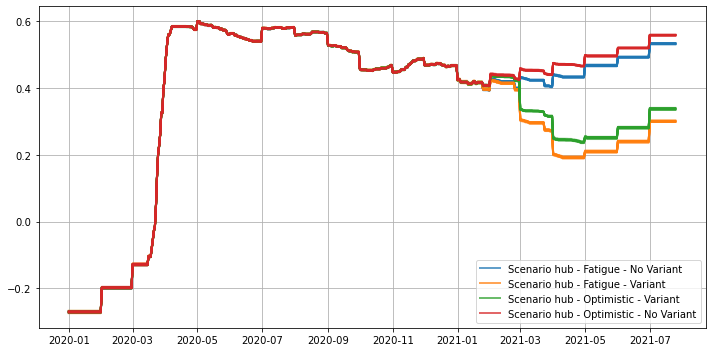

In [41]:
fig, axes = plt.subplots(1,1, figsize = (10,5))

colors = ['r', 'b','orange', 'green']
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728']
ax = axes
i = 0
for name, dc in all_runs.items():
    label = name
    for sim, ts in enumerate(betas[name]):
        ax.plot(ts.mean(axis=1), colors[i],  ls='-', alpha=0.7, label = label, lw=2) # lw = int(sim),
        label = '_'
       
       # ax.set_yscale('log')
    i+=1
fig.tight_layout()
fig.set_facecolor('white')
ax.legend()
ax.grid()
#ax.set_ylim(0.4,0.6)

In [47]:
np.sqrt(55)

7.416198487095663

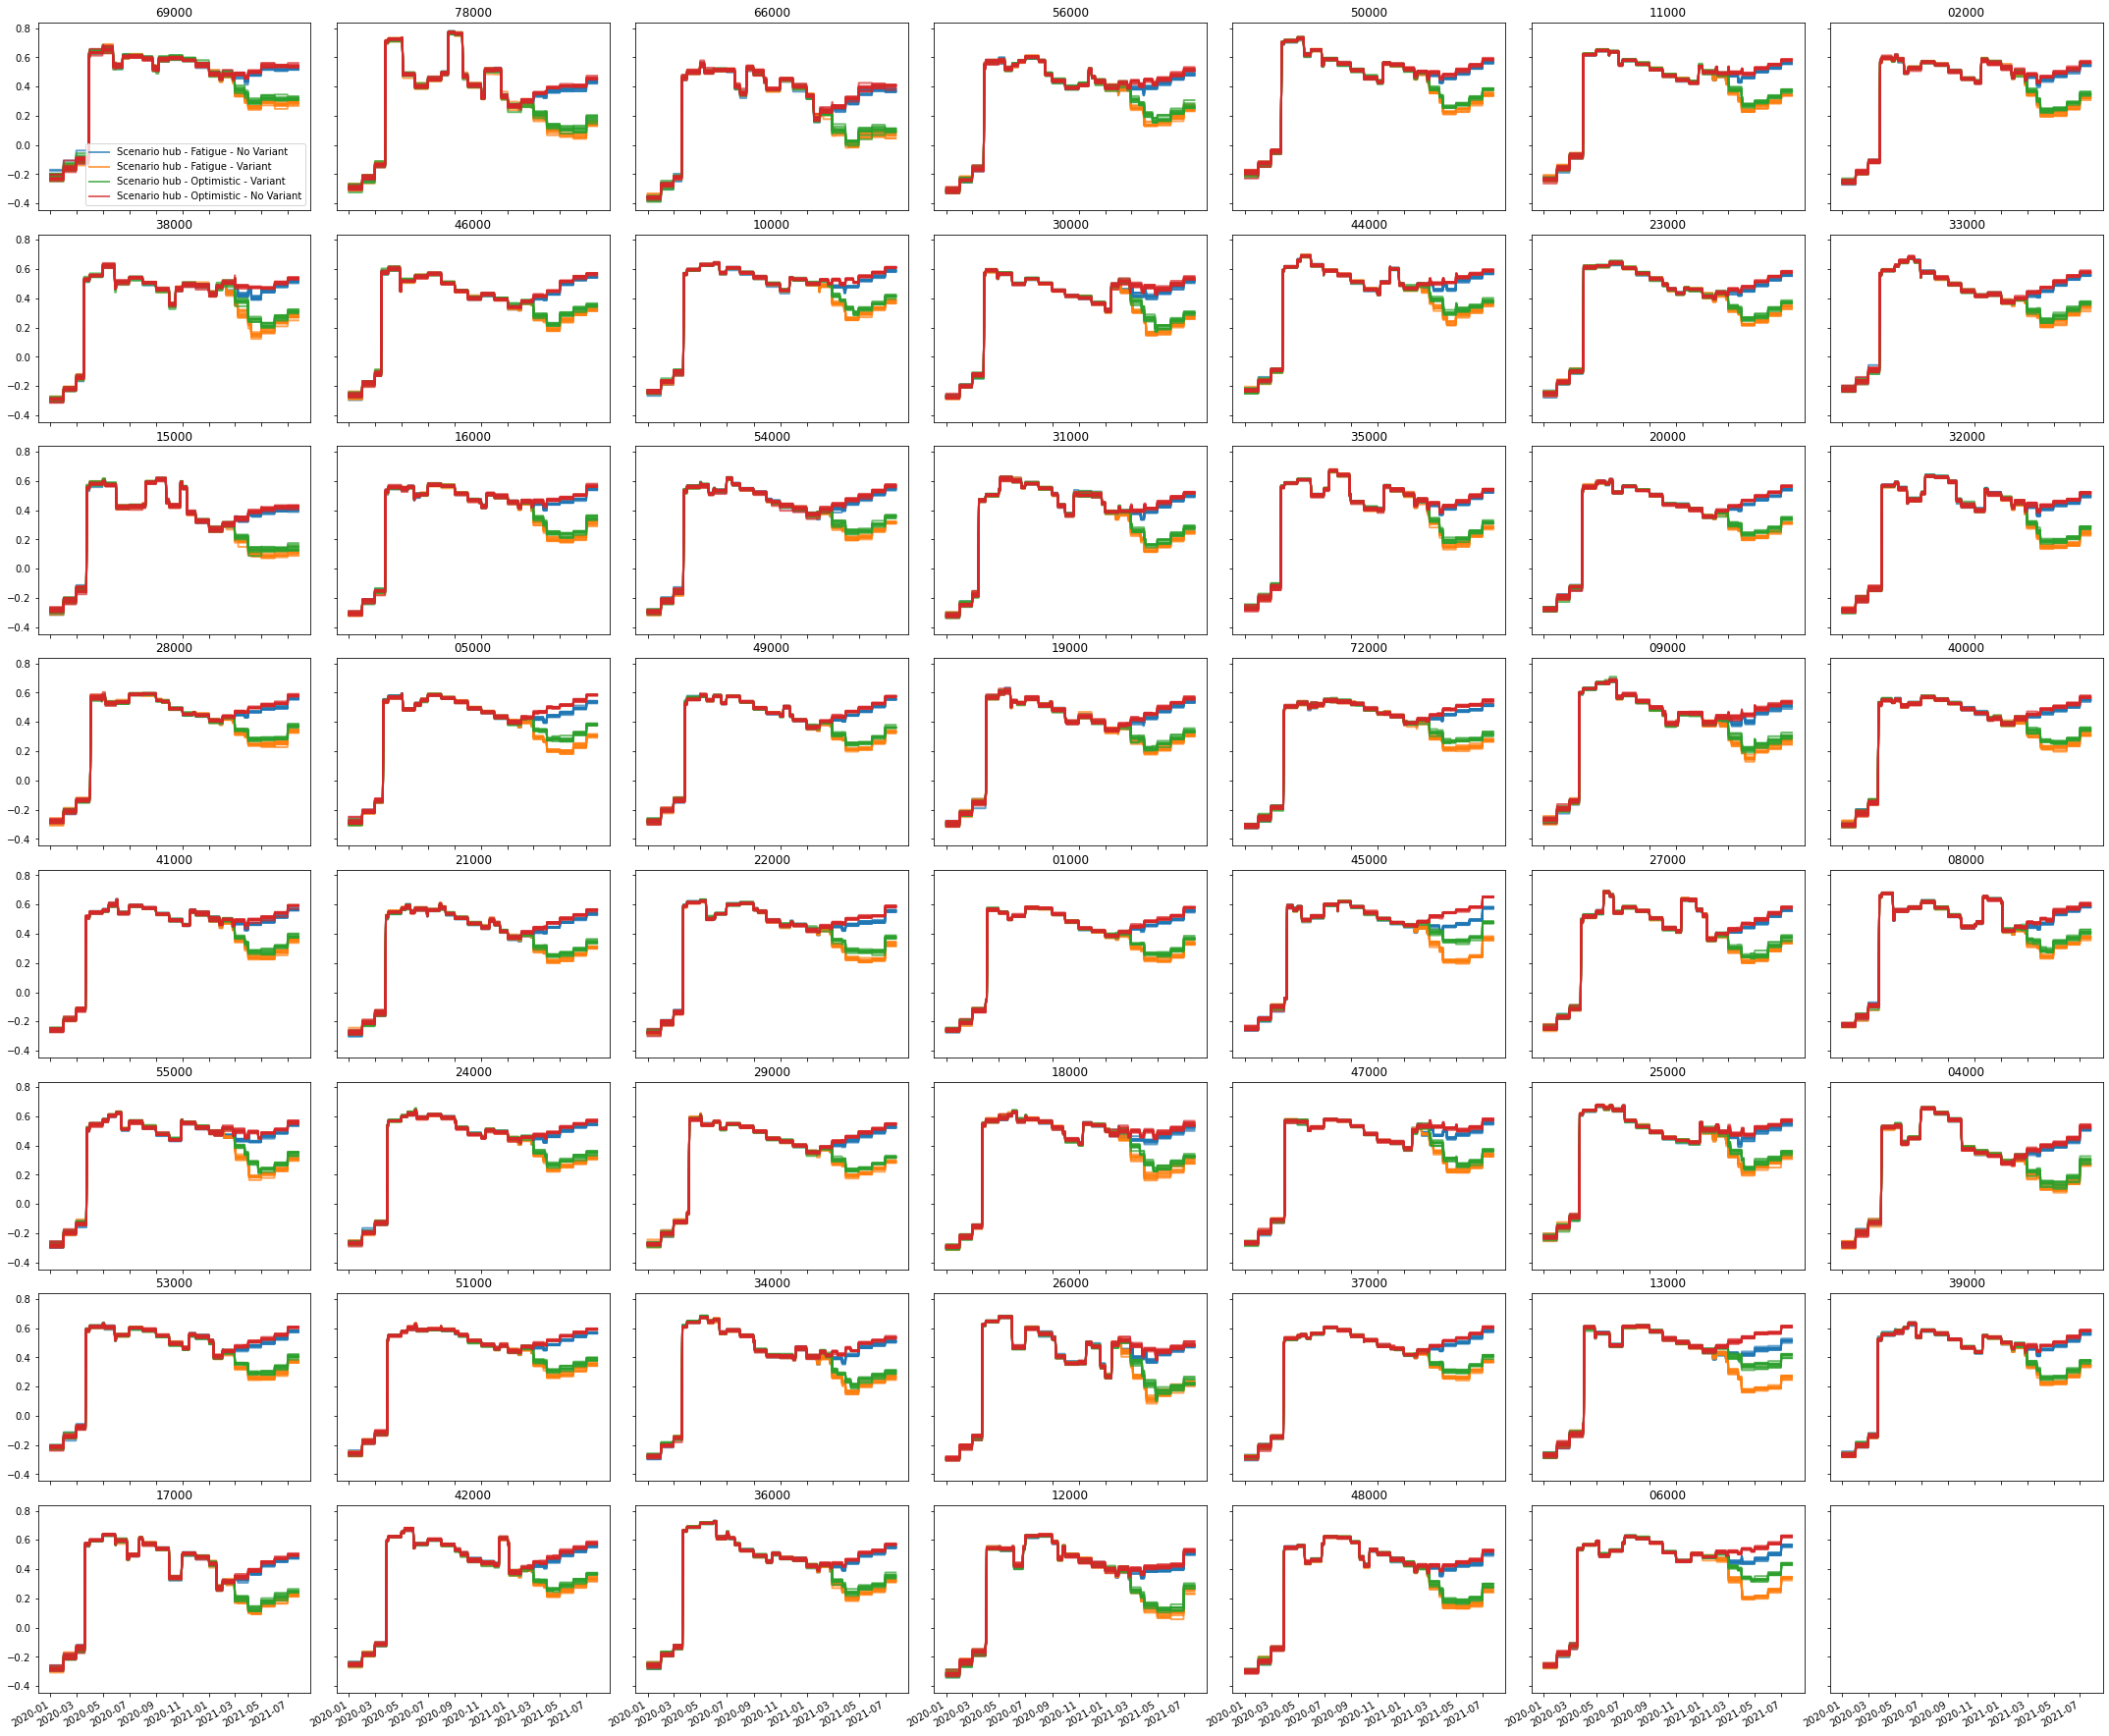

In [46]:
fig, ax = plt.subplots(8,7, figsize = (30,30), sharex = True, sharey=True)
fig.set_facecolor('white')
#colors = ['r', 'b']
j = 0

for name, dc in all_runs.items():
    k=0
    for sim, ts in enumerate(betas[name]):
        for i, nd in enumerate(s.spatset.nodenames):
            if  k == 0:
                ax.flat[i].plot(ts[nd], color = colors[j], alpha = .7, lw = 2, label = name)
                k = 1
            else:
                ax.flat[i].plot(ts[nd], color = colors[j], alpha = .7, lw = 2)
            ax.flat[i].set_title(nd)
            ax.flat[i].grid()
                
    j += 1
ax.flat[0].legend()
fig.tight_layout()
fig.autofmt_xdate()
fig.savefig('seir_npi.pdf')

# NON COMPARISON CONVERGENCE ANALYSIS

In [4]:
for name, dc in all_runs.items():

    config.clear()
    config.read(user=False)
    config.set_file(dc['config'])
    scenario = 'inference'
    deathrate = 'med'
    spatial_config = config["spatial_setup"]
    stoch_traj_flag = True
    index = 0
    run_id = 0
    prefix = 0
    spatial_base_path = pathlib.Path(dc['geodata'] + spatial_config["base_path"].get())
    scenario = scenario
    deathrate = deathrate
    stoch_traj_flag= stoch_traj_flag # Truthy: stochastic simulation, Falsy: determnistic mean of the binomial draws
    nsim = 10
    interactive = False
    write_csv = False
    write_parquet = True
    npi_df = []

    s = setup.Setup(
        setup_name=config["name"].get() + "_" + str(scenario),
        spatial_setup=setup.SpatialSetup(
            setup_name=spatial_config["setup_name"].get(),
            geodata_file=spatial_base_path / spatial_config["geodata"].get(),
            mobility_file=spatial_base_path / spatial_config["mobility"].get(),
            popnodes_key=spatial_config["popnodes"].get(),
            nodenames_key=spatial_config["nodenames"].get()
        ),
        nsim=nsim,
        npi_scenario=scenario,
        npi_config=config["interventions"]["settings"][scenario],
        seeding_config=config["seeding"],
        ti=config["start_date"].as_date(),
        tf=config["end_date"].as_date(),
        interactive=interactive,
        write_csv=write_csv,
        write_parquet=write_parquet,
        dt=config["dt"].as_number(),
        first_sim_index = index,
        in_run_id = run_id,
        in_prefix = prefix,
        out_run_id = run_id,
        out_prefix = prefix
    )

    folder = [x for x in Path(dc['path']).glob('**') if not x.is_file()]

    folder.reverse()

    slots_id = np.arange(1,2)

    betas = {blk:{} for blk in slots_id}

    for fold in folder:
        print(fold)
        print(f'Exploring {str(fold)[:]} ... ', end = '')
        files_loaded = 0
        for hpar_fn in tqdm(Path(str(fold)).rglob('*.parquet')):
            hpar_fn = str(hpar_fn)
            if ('chimeric' not in hpar_fn):
                #hpar =  pq.read_table(hpar_fn).to_pandas()
                #delay = int(list(hpar[(hpar['outcome']=='incidC') & (hpar['quantity'] == 'delay')].value)[0])
                #vals = list(hpar[(hpar['outcome']=='incidC') & (hpar['quantity'] == 'probability')].value)
                #hospf = pq.read_table(hpar_fn.replace('hpar', 'hosp')).to_pandas()
                #seirf = pq.read_table(hpar_fn.replace('hpar', 'seir')).to_pandas()
                slot = int(hpar_fn.split('/')[-1].split('.')[0])
                sim = hpar_fn.split('/')[-1].split('.')[1]
                if slot in slots_id and not isinstance(sim, str):
                    sim = int(sim)
                    snpi = pq.read_table(hpar_fn).to_pandas()
                    #spar = pq.read_table(hpar_fn.replace('hpar', 'spar')).to_pandas()
                    npi = NPI.NPIBase.execute(
                        npi_config=s.npi_config,
                        global_config=config,
                        geoids=s.spatset.nodenames,
                        loaded_df = snpi)
                    p_draw = setup.parameters_load(hpar_fn.replace('snpi', 'spar')[:-8],
                        'parquet',
                        len(s.t_inter),
                        s.nnodes
                    )

                    parameters = setup.parameters_reduce(p_draw, npi, s.dt)
                    betas[slot][sim] = npi.getReduction('r0').T['06000']#.mean(axis=1) #parameters[1].mean(axis = 1)

                    #reduc = snpi.set_index('npi_name').T
                    #reduc.columns = [n.lower() for n in reduc.columns]
                    #reduc = reduc.loc[['reduction','geoid']].T.reset_index()
                    #reduc['reduction'] = pd.to_numeric(reduc['reduction'])
                    #npi_df = npi_df.append(reduc)

                    files_loaded += 1

        print(files_loaded, 'files read')



2361it [00:00, 47195.52it/s]

state-runs/local_run_incomplete/snpi/USA/inference/med/mytestrun$/global/intermediate
Exploring state-runs/local_run_incomplete/snpi/USA/inference/med/mytestrun$/global/intermediate ... 0 files read


In [47]:
npi.getReduction('r0').T['06000']

2020-01-01   -0.019893
2020-01-02   -0.019893
2020-01-03   -0.019893
2020-01-04   -0.019893
2020-01-05   -0.019893
                ...   
2021-02-16    0.589713
2021-02-17    0.589713
2021-02-18    0.589713
2021-02-19    0.589713
2021-02-20    0.589713
Freq: D, Name: 06000, Length: 417, dtype: float64

In [55]:
np.arange(1,1)

array([], dtype=int64)

In [58]:
betas[blk]

{1: 2020-01-01   -1.283567
 2020-01-02   -1.283567
 2020-01-03   -1.283567
 2020-01-04   -1.283567
 2020-01-05   -1.283567
                 ...   
 2021-02-16   -0.133622
 2021-02-17   -0.133622
 2021-02-18   -0.133622
 2021-02-19   -0.133622
 2021-02-20   -0.133622
 Freq: D, Name: 06000, Length: 417, dtype: float64, 0: 2020-01-01   -0.356455
 2020-01-02   -0.356455
 2020-01-03   -0.356455
 2020-01-04   -0.356455
 2020-01-05   -0.356455
                 ...   
 2021-02-16    0.379761
 2021-02-17    0.379761
 2021-02-18    0.379761
 2021-02-19    0.379761
 2021-02-20    0.379761
 Freq: D, Name: 06000, Length: 417, dtype: float64}

In [ ]:
fig, axes = plt.subplots(3,3, figsize = (15,10), sharex = True, sharey = True, dpi = 300)

cmap = cm.gist_heat
normalize = mcolors.Normalize(vmin=1, vmax=20)

for blk in slots_id:
    ax = axes.flat[blk-1]
    for sim, ts in betas[blk].items():
        color = cmap(normalize(int(sim)))
        ax.plot(ts,  alpha = 1, lw = 2, c=color)
        ax.set_title(f'random slot {blk}')
        ax.set_ylim(0.05, 0.4)
        ax.set_ylim(0.05, 1.2)
        ax.grid()
       # ax.set_yscale('log')
fig.tight_layout()
fig.set_facecolor('white')
s_map = cm.ScalarMappable(norm=normalize, cmap=cmap)
fig.colorbar(s_map, label = 'block')#, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g')

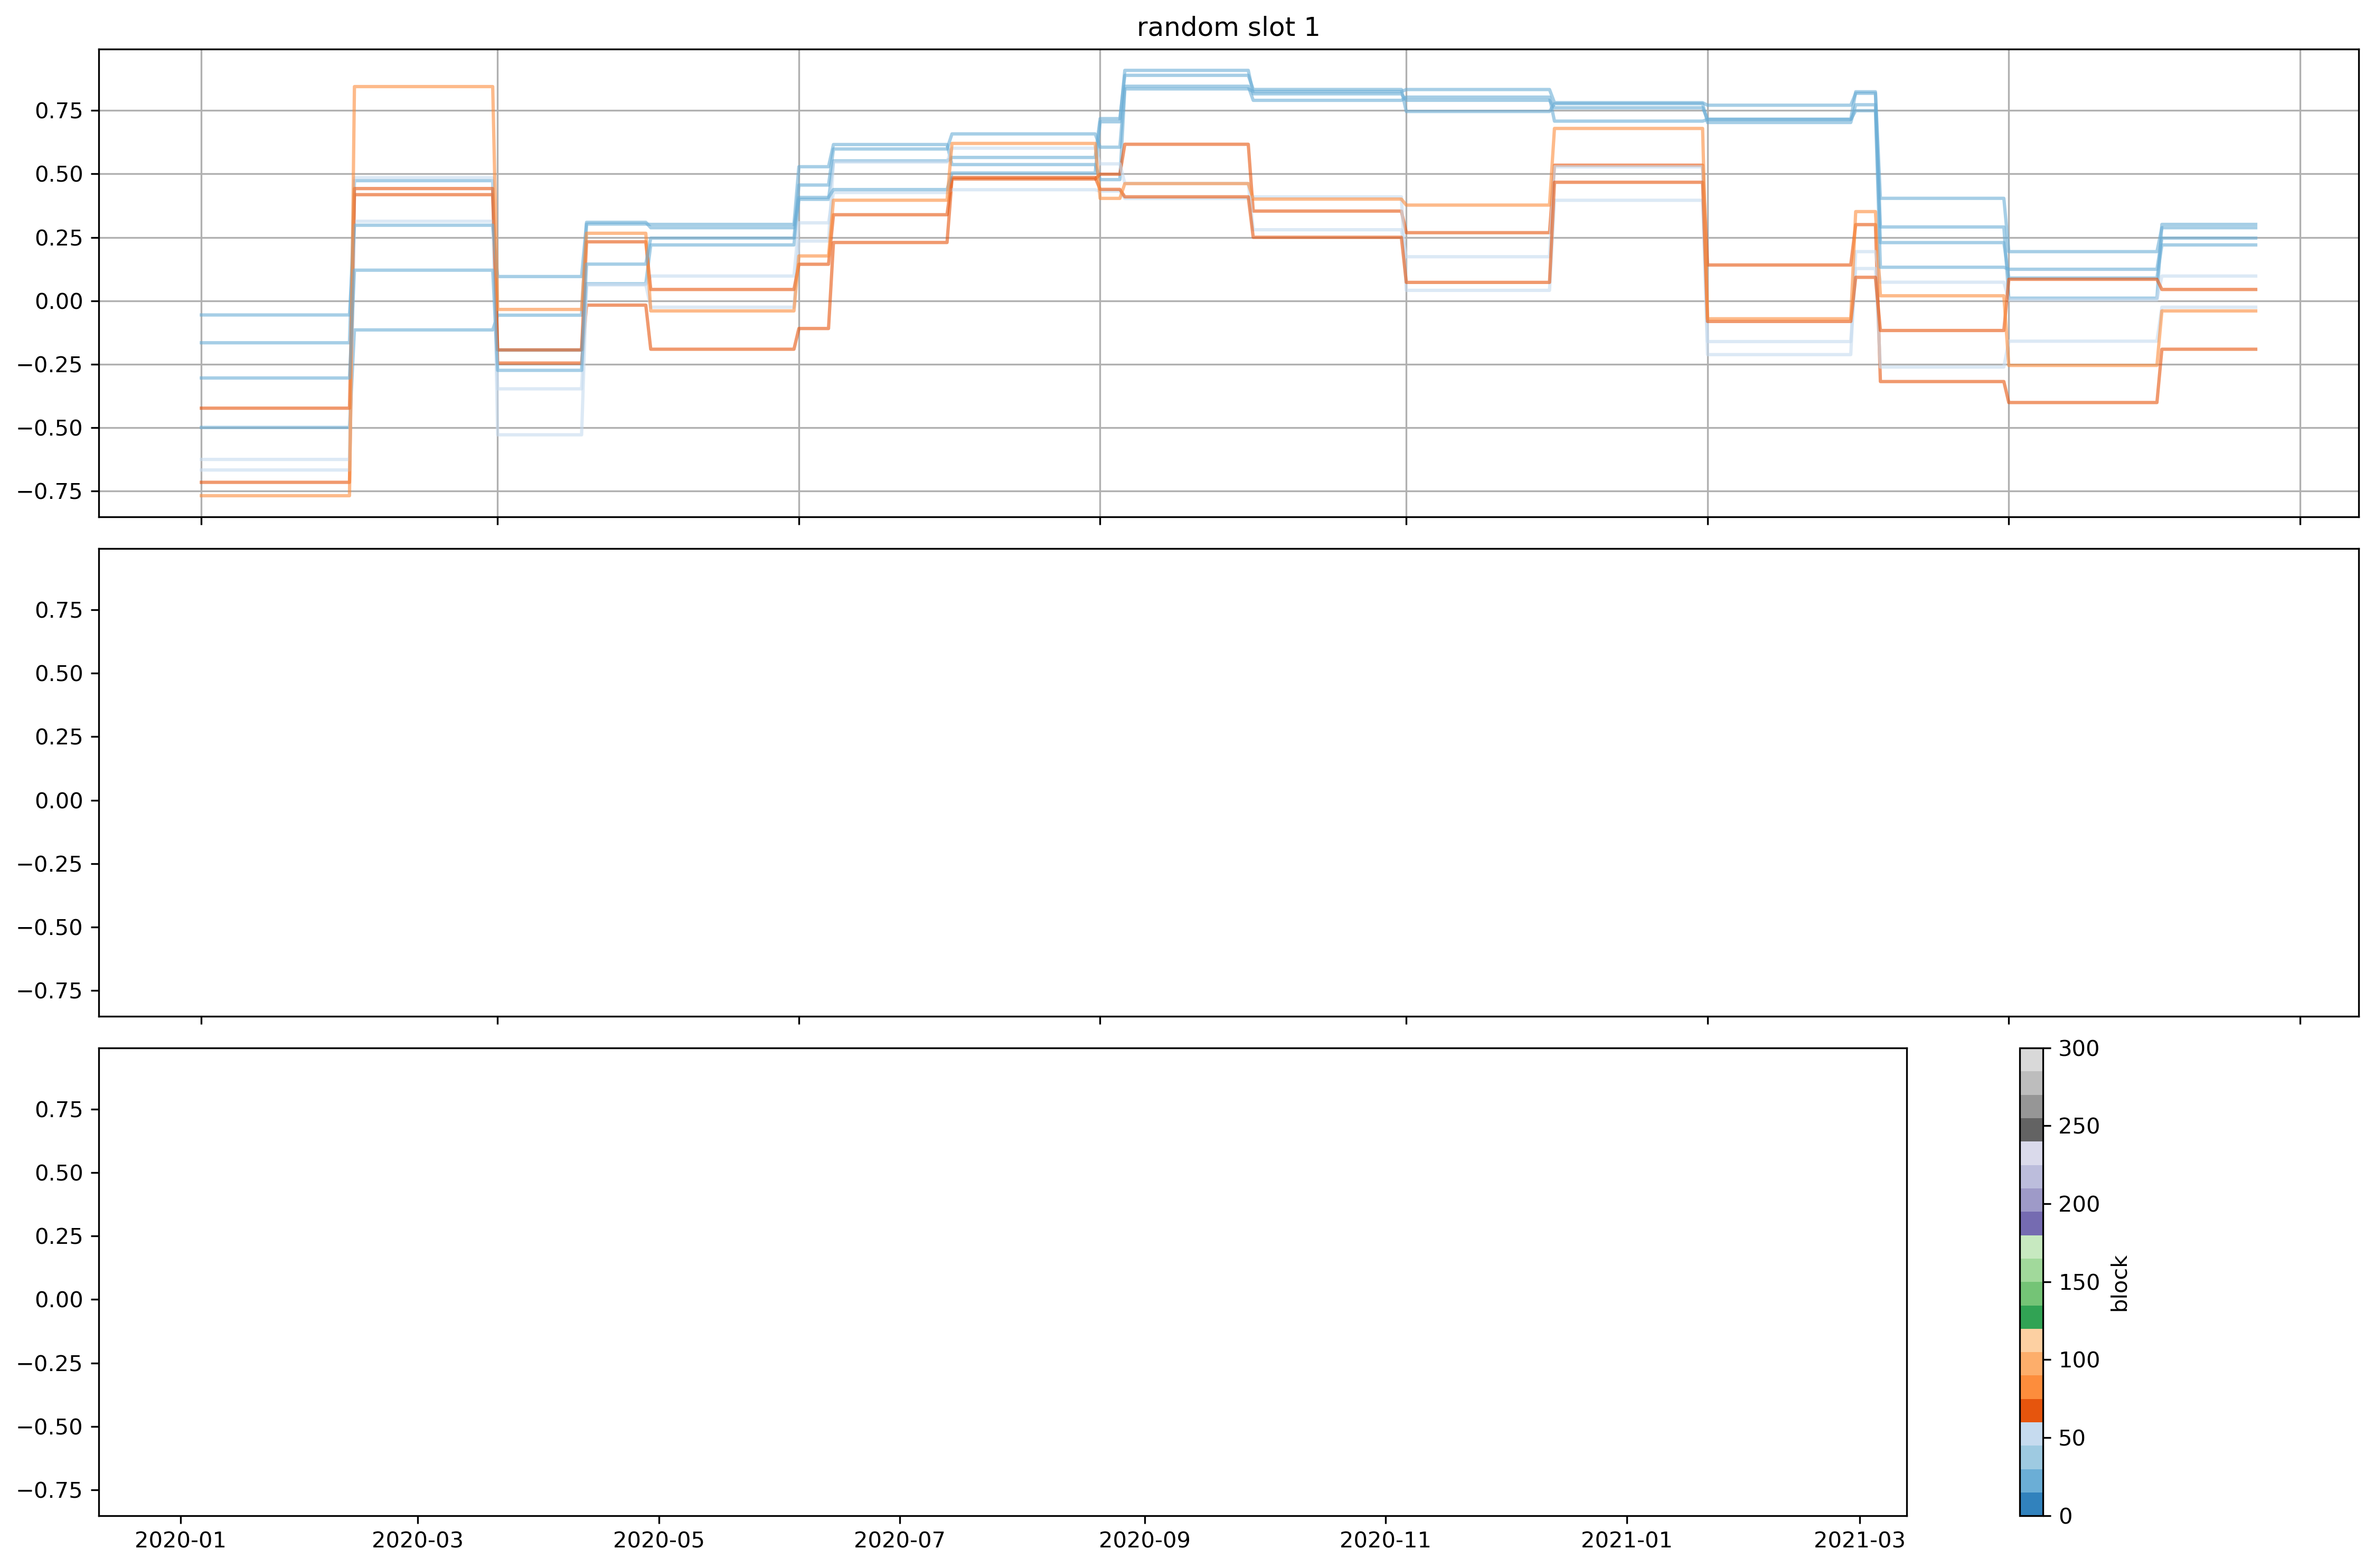

In [67]:
fig, axes = plt.subplots(3,1, figsize = (15,10), sharex = True, sharey = True, dpi = 300)

cmap = cm.gist_heat
cmap = cm.tab20c
normalize = mcolors.Normalize(vmin=0, vmax=300)

for blk in slots_id:
    ax = axes.flat[blk-1]
    for sim, ts in betas[blk].items():
        color = cmap(normalize(int(sim)))
        ax.plot(ts,   ls='-', c=color, alpha=0.6) # lw = int(sim),
        ax.set_title(f'random slot {blk}')

        ax.grid()
       # ax.set_yscale('log')
fig.tight_layout()
fig.set_facecolor('white')
s_map = cm.ScalarMappable(norm=normalize, cmap=cmap)
fig.colorbar(s_map, label = 'block')#, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g')

local_variance -0.0029207732391570563
seas_jan -0.018374651613446886
seas_feb -0.011791856925595057
seas_mar -0.005798626480093571
seas_may 0.007591128728286578
seas_jun 0.010935493646575535
seas_jul 0.0199149848170324
seas_aug 0.011977344923638283
seas_sep 0.004482483930885648
seas_oct 0.0007365220774217009
seas_nov -0.005374446931024407
root 0.014298376173680226
bar_closure_1 0.09239814164538165
root 0.09239814164538164
compliance 0.07492270320206751
dine_closure_1 0.07569013777450567
root 0.07569013777450567
hair_closure_1 0.06533183683040643
root 0.06533183683040643
isolation 0.08719067093239043
malls_closure_1 0.07252697624846045
root 0.07252697624846045
masks_1 0.07215170559202254
root 0.07215170559202254
park_closure_1 0.0868414360504697
root 0.0868414360504697
quarantine 0.08297581943531245
school_closure_1 0.07430509799875912
root 0.07430509799875912
stay_at_home_1 0.0830188505516945
root 0.0830188505516945
worship_closure_1 0.07276108085358521
root 0.07276108085358521


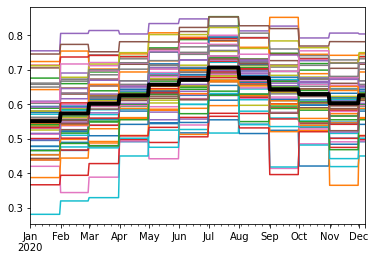

In [3]:
npi = NPI.NPIBase.execute(
    npi_config=s.npi_config,
    global_config=config,
    geoids=s.spatset.nodenames,
    #loaded_df = snpi
)
ax = npi.getReduction('r0').T.plot(legend=False);
npi.getReduction('r0').T.mean(axis=1).plot(legend=False, ax = ax, lw = 4, c='k');
ax.set_facecolor('white')

In [104]:
s.npi_config['scenarios'].get()

['local_variance',
 'seasonal',
 'bar_closure',
 'compliance',
 'dine_closure',
 'hair_closure',
 'isolation',
 'malls_closure',
 'masks',
 'park_closure',
 'quarantine',
 'school_closure',
 'stay_at_home',
 'worship_closure']

In [7]:
import confuse
scenario = 'hair_closure_1'

In [8]:
settings_map = config["interventions"]["settings"].get()
settings = settings_map.get(scenario)
if settings is None:
    raise RuntimeError(f"couldn't find scenario in config file [got: {scenario}]")
# via profiling: faster to recreate the confuse view than to fetch+resolve due to confuse isinstance
# checks
scenario_npi_config = confuse.RootView([settings])
scenario_npi_config.key = scenario
print(scenario_npi_config["value"].get())

RuntimeError: couldn't find scenario in config file [got: hair_closure_1]

In [9]:
rd = scenario_npi_config["value"].as_random_distribution()(size=100000)
plt.hist(rd);
print(rd.mean())

NameError: name 'scenario_npi_config' is not defined

7.413915442301942e-05
0.00014625548015080678


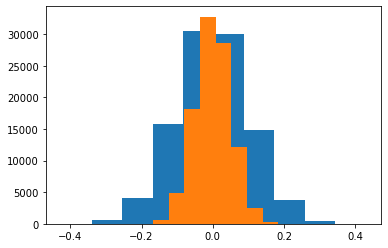

In [21]:
import scipy
def truncated_normal(*, mean=0, sd=1, a=0, b=10):
    return scipy.stats.truncnorm((a - mean) / sd, (b - mean) / sd, loc=mean, scale=sd).rvs

rd = truncated_normal(mean=0.0, sd = 0.1, a=-1, b=1)(size=100000)

plt.hist(rd);
print(rd.mean())

rd = truncated_normal(mean=0.0, sd = 0.05, a=-1, b=1)(size=100000)

plt.hist(rd);
print(rd.mean())

NameError: name 'blocks_id' is not defined

In [7]:
print('ds')

ds


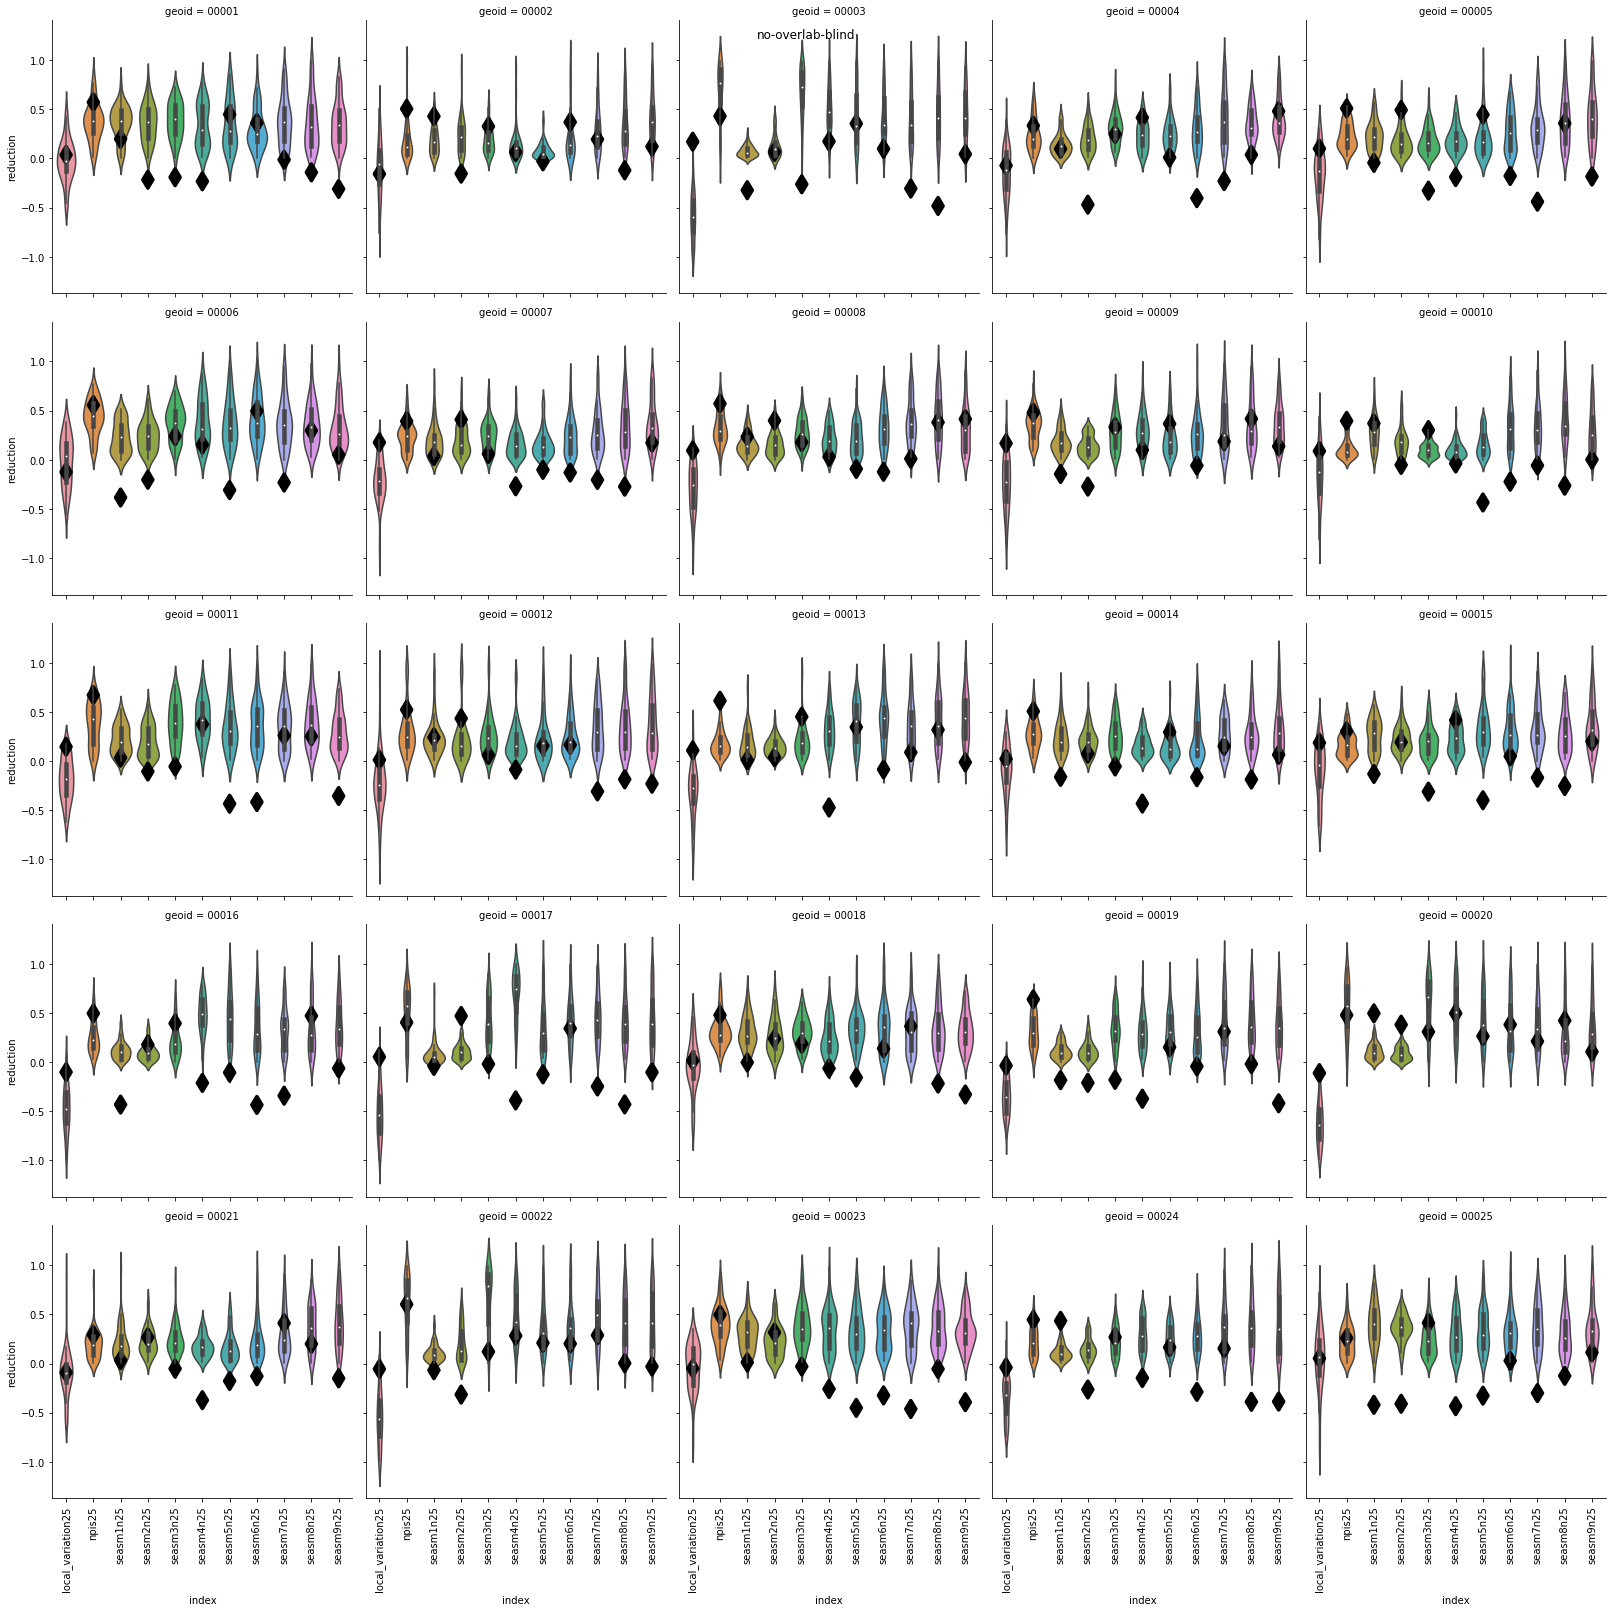

In [3]:
iris = npi_df
#iris = iris.sort_values('index')
#iris = iris[iris['geoid'].isin(['00001', '00002', '00003'])]

grid = sns.FacetGrid(iris, col="geoid", hue="geoid", palette="tab20c", height=4.5, col_wrap=5)


def quantile_plot(index, reduction, **kwargs):
    sns.violinplot(x=index, y=reduction, #hue="geoid",
                   dodge=True,  zorder=1)#Ç, scale='width')#, alpha=.25,capsize=.8, size = .2, errwidth=.75);
    sns.pointplot(x="index", y="reduction", data = npi_truth[npi_truth['geoid']==kwargs['label']], dodge=.532, join=False, #palette="dark",
              markers="d", scale=1.75, ci=None,zorder=102, color="black")
    #plt.scatter((1,1),  **kwargs)

# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, 'index', "reduction" )#, marker="o")

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        
# Adjust the arrangement of the plots
grid.fig.suptitle(run_name)

grid.fig.tight_layout(w_pad=1)

In [4]:
grid.savefig('npi_vals.pdf')

In [5]:
pdf.savefig(grid.fig)

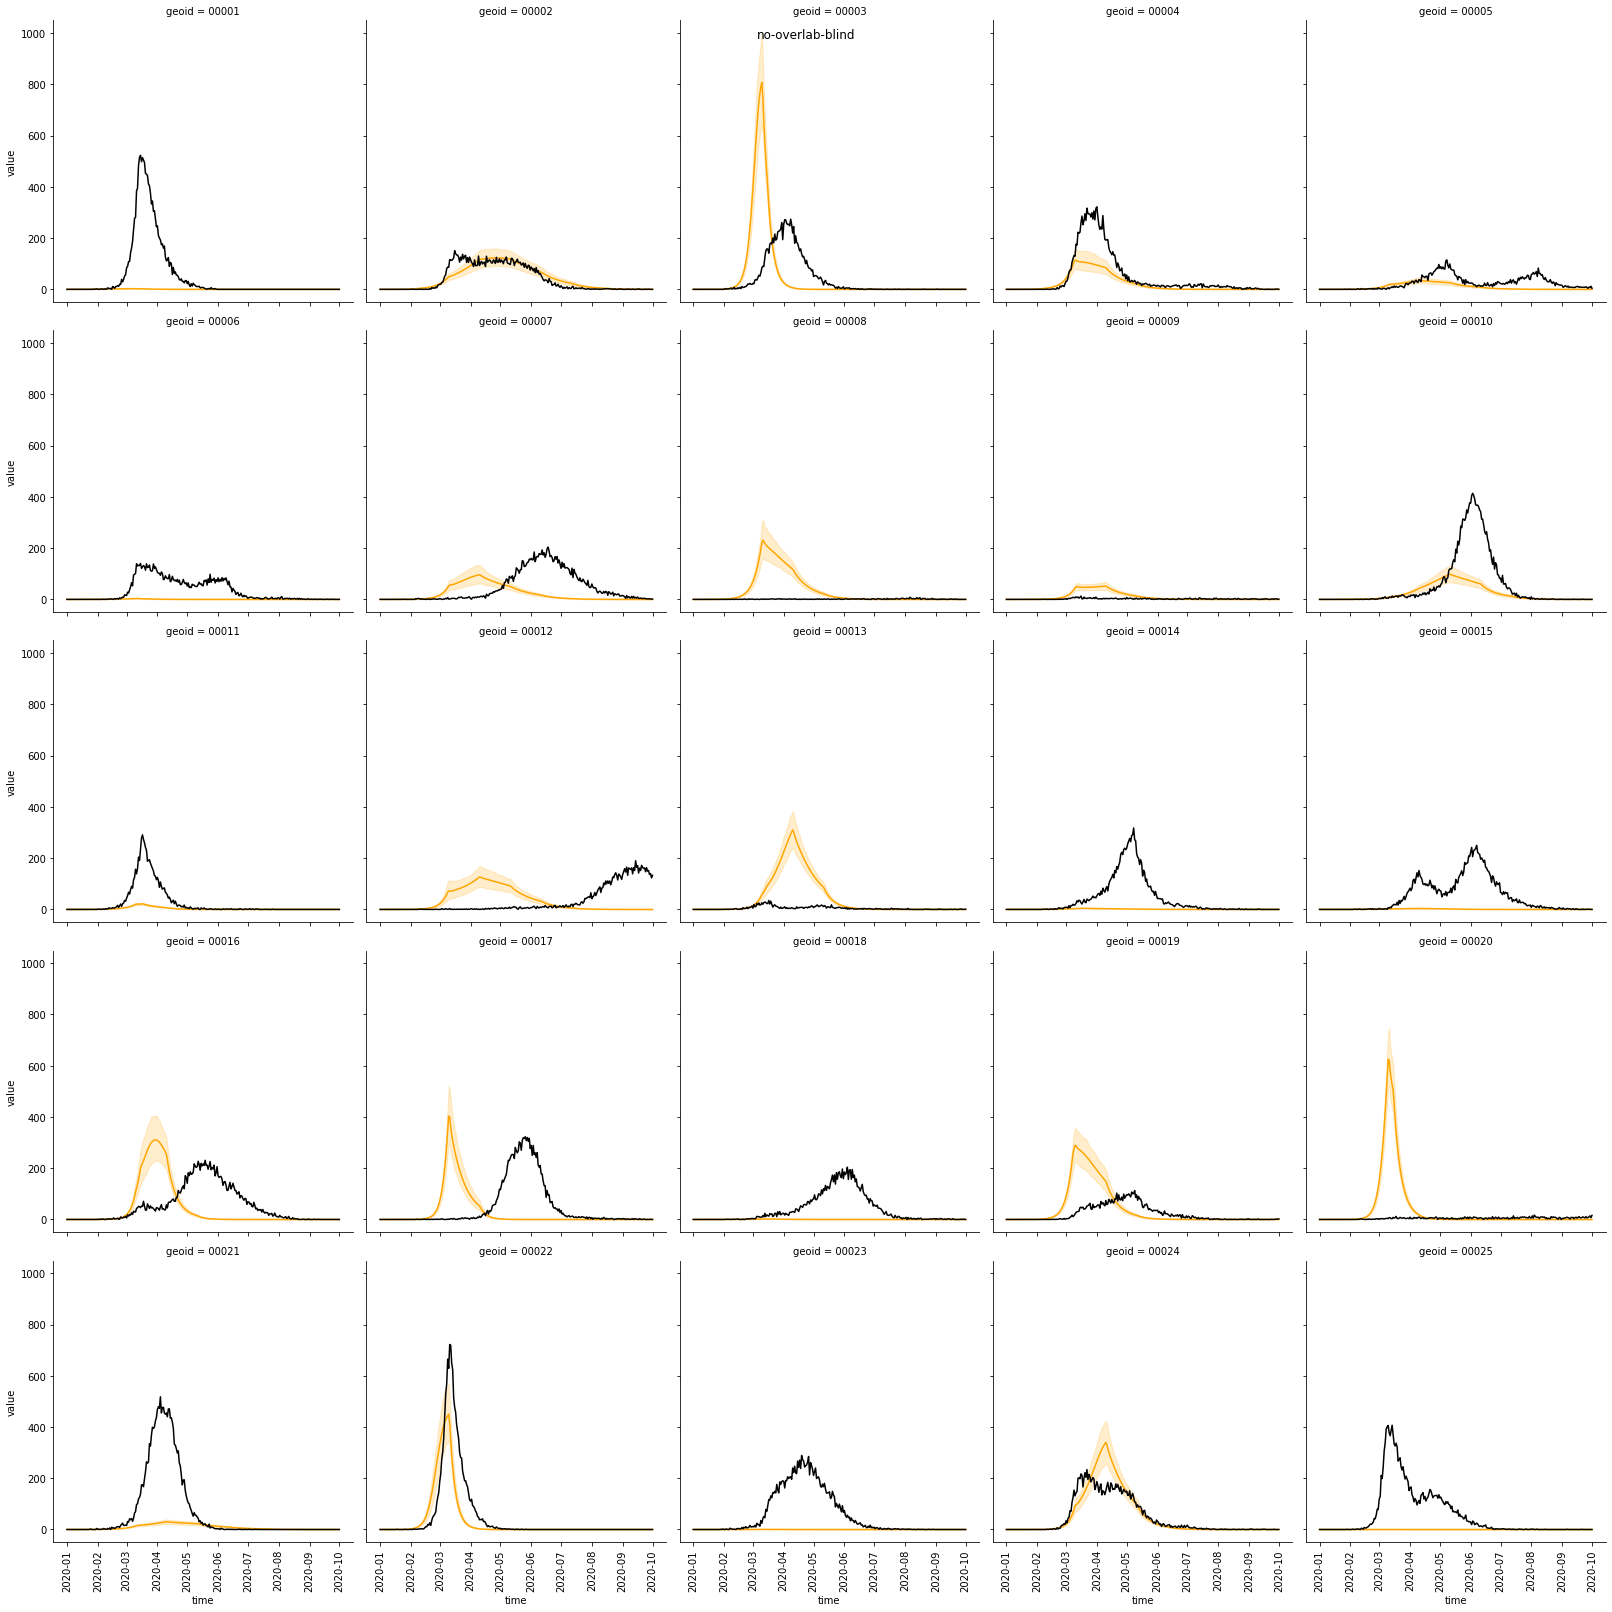

In [6]:
iris = hosp_df[hosp_df['comp']=='incidC']
#iris = iris.sort_values('index')
#iris = iris[iris['geoid'].isin(['00001', '00002', '00003'])]

grid = sns.FacetGrid(iris, col="geoid", hue="geoid", palette="tab20c", height=4.5, col_wrap=5)

# Draw a horizontal line to show the starting point
#grid.map(plt.axhline, y=0, ls=":", c=".5")

def quantile_plot(index, reduction, **kwargs):
    sns.lineplot(x=index, y=reduction, color = 'orange',#hue="geoid",
                    zorder=1)#Ç, scale='width')#, alpha=.25,capsize=.8, size = .2, errwidth=.75);
    sns.lineplot(x="time", y="value", data = hosp_truth[(hosp_truth['comp']=='incidC') & (hosp_truth['geoid']==kwargs['label'])],color="black")
                  #dodge=.532, join=False, #palette="dark",
             # markers="d", scale=1.75, ci=None,zorder=102, 
    #plt.scatter((1,1),  **kwargs)

# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, 'time', "value" )#, marker="o")

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        
# Adjust the arrangement of the plots
grid.fig.suptitle(run_name)

grid.fig.tight_layout(w_pad=1)

In [7]:
pdf.savefig(grid.fig)

In [14]:
betas = np.array(betas)

In [46]:
betas = betas[:,::4,:]

In [8]:
#all_vals = np.array(all_vals)
#fig, ax = plt.subplots(7,8, figsize = (20,20), sharex = True)
#for i in range(50):
#    ax.flat[i].hist(all_vals[i::50])
#    ax.flat[i].set_title('geoid' + str(i))

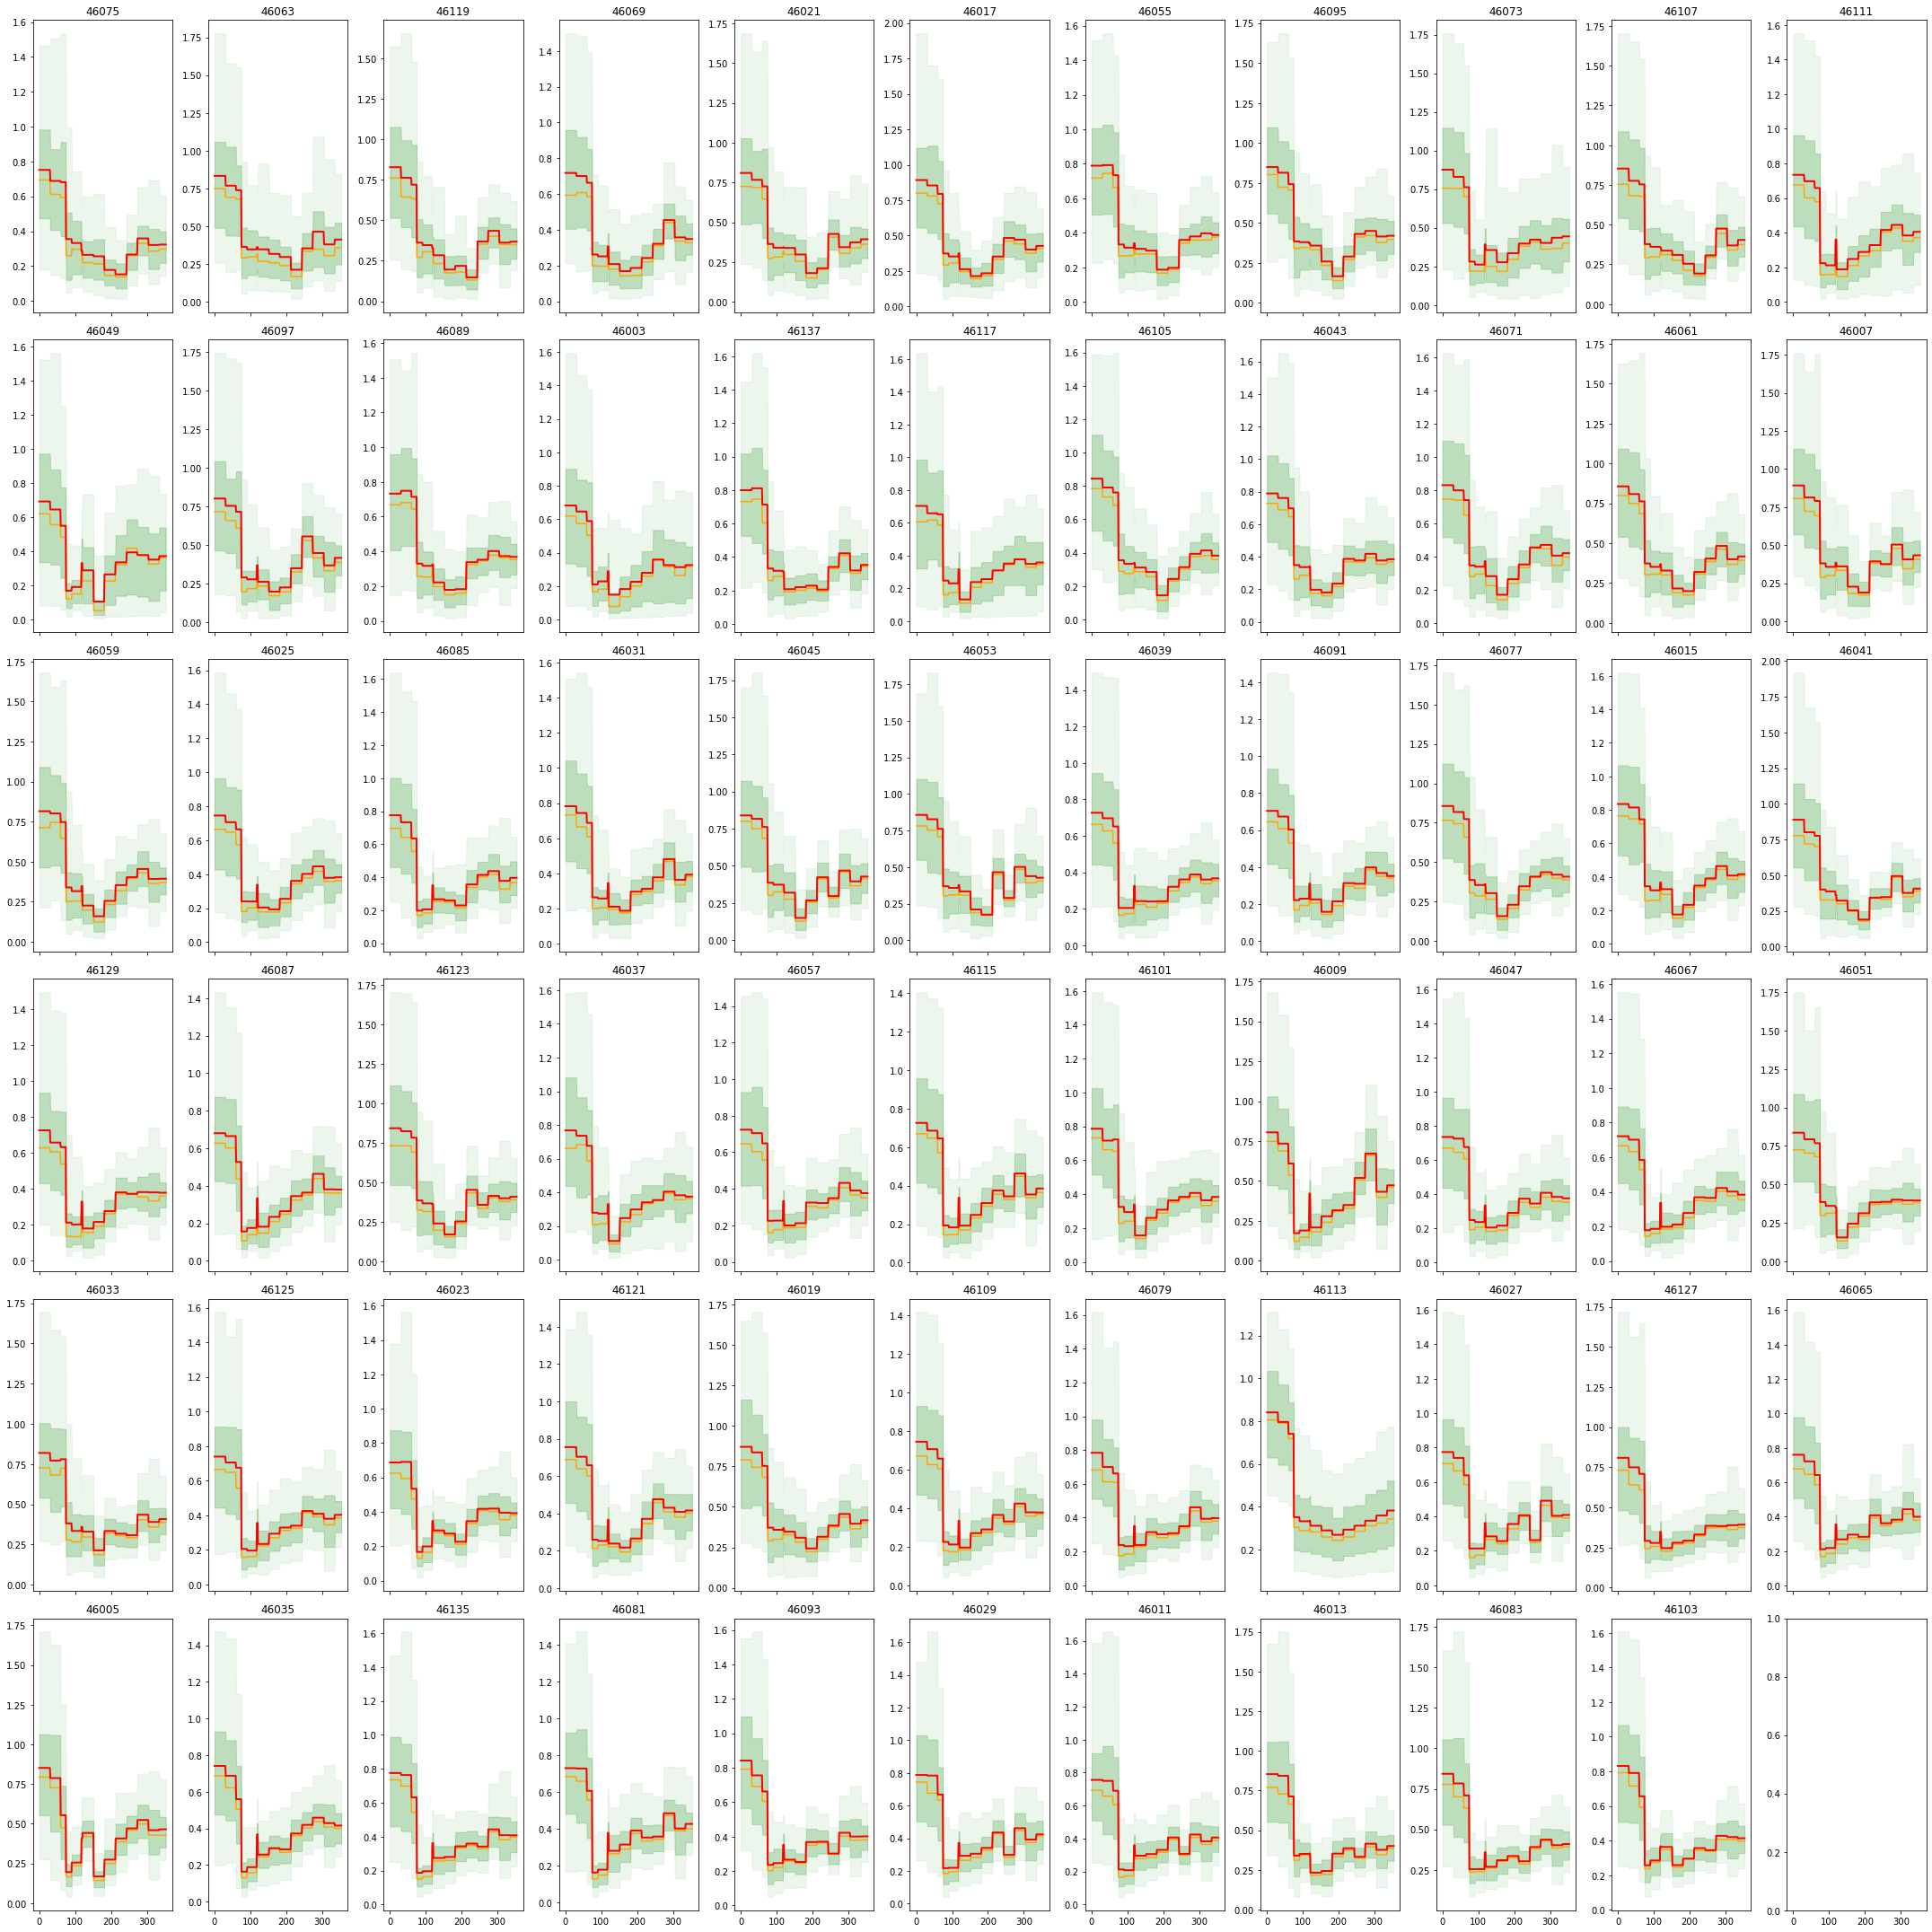

In [47]:
betas = np.array(betas)
fig, ax = plt.subplots(65//10,11, figsize = (30,30), sharex = True)
for i in range(65):
    beta = betas[:,:,i].T
    #ax.flat[i].plot(beta[:,:20], color = 'b', lw = .5, alpha = .5)
    ax.flat[i].fill_between(np.arange(beta.shape[0]), np.quantile(beta,.05,axis=1), np.quantile(beta,.95,axis=1), alpha = .07, color = 'g')
    ax.flat[i].fill_between(np.arange(beta.shape[0]), np.quantile(beta,.25,axis=1), np.quantile(beta,.75,axis=1), alpha = .2, color = 'g')
    ax.flat[i].plot(np.quantile(beta,.5,axis=1), color = 'orange', alpha = 1)
    ax.flat[i].plot(np.mean(beta, axis=1), color = 'r', alpha = 1, lw =2)
    #ax.flat[i].plot(beta_truth[:,i], color = 'k', lw =2)
    ax.flat[i].set_title(s.spatset.nodenames[i])
#fig.suptitle('black is truth | red is mean | blue is 90%');
fig.tight_layout()

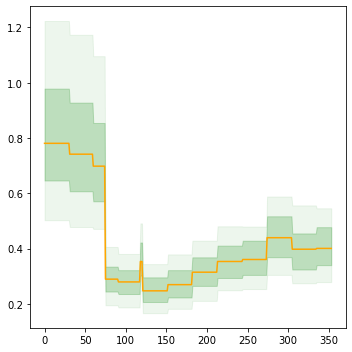

In [48]:

fig, ax = plt.subplots(1,1, figsize = (5,5), sharex = True)

all_beta = np.sum(betas, axis=2)

all_beta = np.zeros_like(betas[:,:,0])
for pl in range(betas.shape[2]):
    all_beta += betas[:,:,pl] * s.spatset.popnodes[pl]
    
all_beta /= s.spatset.popnodes.sum()
    

#ax.flat[i].plot(beta[:,:20], color = 'b', lw = .5, alpha = .5)
ax.fill_between(np.arange(all_beta.shape[1]), np.quantile(all_beta,.05,axis=0), np.quantile(all_beta,.95,axis=0), alpha = .07, color = 'g')
ax.fill_between(np.arange(all_beta.shape[1]), np.quantile(all_beta,.25,axis=0), np.quantile(all_beta,.75,axis=0), alpha = .2, color = 'g')
ax.plot(np.quantile(all_beta,.5,axis=0), color = 'orange', alpha = 1)
#ax.plot(np.mean(beta, axis=1), color = 'r', alpha = 1, lw =2)
#ax.flat[i].plot(beta_truth[:,i], color = 'k', lw =2)
#ax.flat[i].set_title('geoid' + str(i))
#fig.suptitle('black is truth | red is mean | blue is 90%');
fig.tight_layout()

In [10]:
fig.savefig('beta_vals.pdf')

In [31]:
betas.shape

(300, 1413, 66)

In [12]:
pdf.close()

In [19]:
np.quantile(np.sumbeta,.5,axis=1).shape

(300,)

In [24]:
np.sum(betas, axis=2

(300, 1413)

In [36]:
betas.shape

(300, 1413, 66)

In [49]:
1400/4

350.0